In [1]:
# %% import package to use
import datatable
import pandas as pd
from IPython.display import display
import numpy as np
import os
from sklearn.metrics import accuracy_score
from imblearn.metrics import sensitivity_specificity_support
import matplotlib.pyplot as plt

from sklearn.metrics import log_loss
import xgboost as xgb
pd.set_option('display.max_columns', None)

from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

from sklearn.metrics import confusion_matrix, auc, roc_curve, precision_recall_curve

In [2]:
import pickle

#### XGBoost
with open('../asthma_xg_classifier_full.pickle', 'rb') as file_nm:
    results = pickle.load(file_nm)
    
df_results_xg = pd.DataFrame()
for condition in results:
    df_results_xg = pd.concat((df_results_xg, pd.DataFrame(results[condition])), axis=0)

xg_best_param = df_results_xg[df_results_xg['mean_mse'] == df_results_xg['mean_mse'].min()][['max_depth', 'learning_rate', 'lambda', 'gamma', 'scores', 'mse_loss']].reset_index(drop=True)

In [3]:
# %% Load dataset
DATA_PATH = "/home/lkh256/Studio/Asthma"
df_init = datatable.fread(os.path.join(DATA_PATH, 'dataset.csv'), 
                          encoding='utf-8-sig', 
                          na_strings=['', 'NA']).to_pandas()

print("Number of samples = {}".format(len(df_init)))

# %% Check missings
print("Check their is any missing variables in dataset: \n", df_init.isnull().sum())

# %%
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df_init,  
                                       random_state=1004, 
                                       stratify=df_init['asthma'], 
                                       test_size=0.2)

print("Train set size = {}".format(len(train_set)))
print("Test set size = {}".format(len(test_set)))

X_train = train_set.drop(columns=['asthma']).values
y_train = train_set['asthma'].values
dtrain = xgb.DMatrix(X_train, label=y_train)

X_test = test_set.drop(columns=['asthma']).values
y_test = test_set['asthma'].values
dtest = xgb.DMatrix(X_test, label=y_test)


Number of samples = 756
Check their is any missing variables in dataset: 
 age                       0
sex                       0
Squamouscell              0
Marcrophage               0
Neutrophil                0
sp_eosinophil             0
Other                     0
Epithelialcell            0
salineFVC                 0
80%FEV1                   0
PC20_mgpml              287
maxFall_FEV1_percent    136
FeNO                      1
dyspnea                   3
cough                     3
wheezing                  4
rhinitis                  2
smoking                 184
IgE                     333
FEV1_0_percent            1
FVC_afterMBPT             2
FEV1_afterMBPT            2
FEF2575_afterMBPT         3
FEV1_FVC_0                0
Bl_eos_count            296
BMI                     628
mbpt                      0
asthma                    0
dtype: int64
Train set size = 604
Test set size = 152


## XGBoost

In [4]:
xg_best_param.head(1)

,max_depth,learning_rate,lambda,gamma,scores,mse_loss
0,5,0.001,2,0.2,0.85124,0.338904


In [5]:
import xgboost as xgb

params = {'objective': "binary:logistic", 
          'eval_metric': 'logloss',
          'tree_method': 'gpu_hist', 
          'gpu_id': '0',
          'learning_rate': 0.001, 
          'max_depth': 5,
          'lambda': 2,
          'gamma': 0.2}

model_xgb = xgb.train(params, dtrain, 
                    num_boost_round=20000, 
                    evals=[(dtest, 'test')], 
                    verbose_eval=0, 
                    early_stopping_rounds=1000)

In [6]:
print("Train accuracy", accuracy_score(y_train, model_xgb.predict(dtrain) > 0.5))
print("Test accuracy", accuracy_score(y_test, model_xgb.predict(dtest) > 0.5))
print("Train neg_loss : ", log_loss(y_pred=model_xgb.predict(dtrain), y_true=y_train))
print("Test neg_loss", log_loss(y_pred=model_xgb.predict(dtest), y_true=y_test))

Train accuracy 0.9933774834437086
Test accuracy 0.8421052631578947
Train neg_loss :  0.09180798062851146
Test neg_loss 0.3638820639676659


In [7]:
def performances_hard_decision(y_test, y_proba, threshold_of_interest=0.5, youden=False):
   
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
   
    print("AUROC: {:.3f}".format(roc_auc))
   
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    
    print("AUPRC: {:.3f}".format(pr_auc))

    
    if(youden):
        threshold_of_interest = thresholds[np.argmax(tpr - fpr)]
    
    y_pred = y_proba >= threshold_of_interest
   
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    ppv = tp / (tp+fp)
    sensitivity = tp / (tp+fn)
    specificity = tn / (tn+fp)
    npv = tn / (tn+fn)
    accuracy = (tp+tn) / (tp+tn+fp+fn)
    f1 = (2 * ppv * sensitivity) / (ppv + sensitivity)
   
    print("specificity: {:.3f}".format(specificity))
    print("sensitivity: {:.3f}".format(sensitivity))
    print("PPV: {:.3f}".format(ppv))
    print("NPV: {:.3f}".format(npv))
    print("f1: {:.3f}".format(f1))
    print("accuracy: {:.3f}".format(accuracy))
    print("threshold: {:.3f}".format(threshold_of_interest))

# Visualization

In [8]:
def plot_roc_prc(y_hat, y):
    fpr, tpr, _ = roc_curve(y, y_hat, pos_label=1)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
    
    prec, recall, _ = precision_recall_curve(y, y_hat, pos_label=1)
    pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    roc_display.plot(ax=ax1)
    pr_display.plot(ax=ax2)
    plt.show()

In [9]:
df_init['asthma'].value_counts(normalize=True)

False    0.600529
True     0.399471
Name: asthma, dtype: float64

AUROC: 0.919
AUPRC: 0.901
specificity: 0.879
sensitivity: 0.787
PPV: 0.814
NPV: 0.860
f1: 0.800
accuracy: 0.842
threshold: 0.500
None


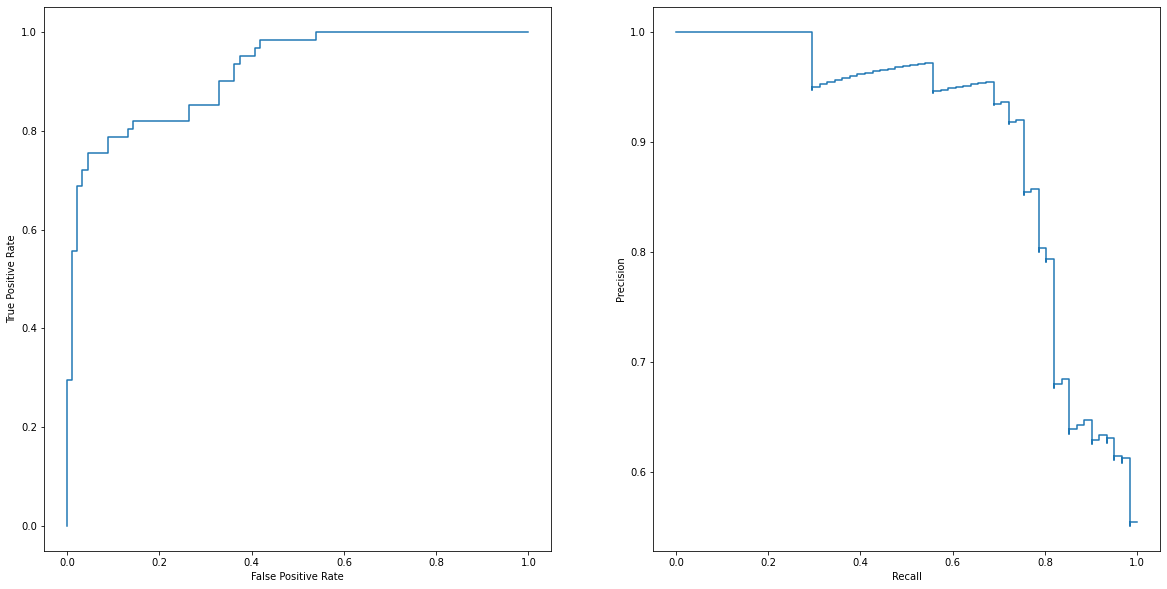

In [10]:
y_hat = model_xgb.predict(dtest)

accuracy = accuracy_score(y_pred=(y_hat > 0.5), y_true=y_test)
sensitivity, specificity, _ = sensitivity_specificity_support(y_true=y_test, y_pred=(y_hat > 0.5), average='binary')

# print("Accuracy: {}".format(accuracy))
# print("Sensitivity: {}".format(sensitivity))
# print("Specificity: {}".format(specificity))        
# print("AUROC: {}".format(roc_auc_score(y_test, y_hat)))
# print("AUPRC: {}".format(average_precision_score(y_test, y_hat)))

print(performances_hard_decision(y_test, y_hat))

plot_roc_prc(y_hat, y_test)

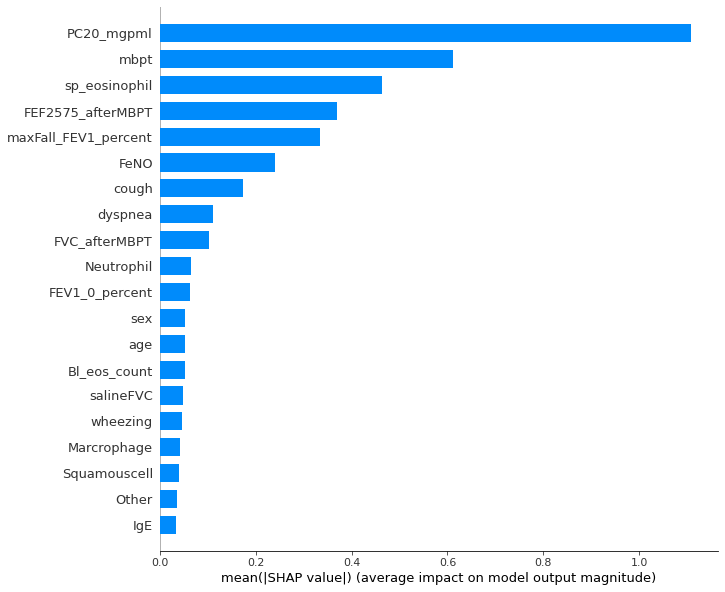

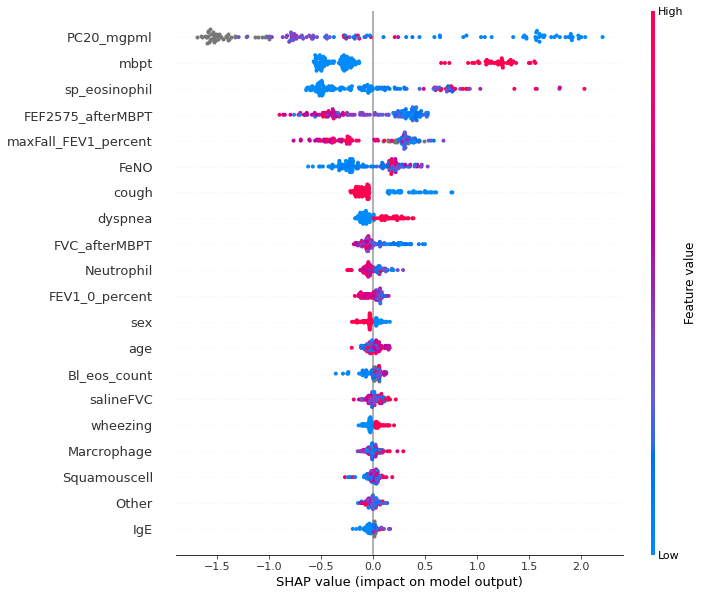

In [11]:
import shap

explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=test_set.columns[:-1], plot_size=(10, 10))

shap.summary_plot(shap_values, X_test, feature_names=test_set.columns[:-1], plot_size=(10, 10))